In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from numpy import inf
import torch.optim as optim
from datetime import datetime
import os, time, argparse, csv
import torch.nn.functional as F
import pickle
from torch.nn.functional import l1_loss, mse_loss
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import l1_loss, mse_loss
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch, math
import torch.nn as nn
import torch.nn.functional as F
import csv
import pickle as pk
from scipy.linalg import null_space
from torch_geometric.data import Data

/gpfs/gibbs/project/krishnaswamy_smita/sv496/conda_envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model construction

In [19]:
# internal files
#from layer.FCN import FCN
class FCN(nn.Module):
    def __init__(self, in_c, nullspace, num_filter=2, label_dim=8, layer=2, dropout=False):
        super(FCN, self).__init__()

        self.layers = nn.ModuleList([nn.Conv1d(in_c, 8, 1), nn.ReLU(), nn.Flatten(),
                                        nn.Linear(nullspace.shape[0], num_filter, bias=True),
                                        #nn.BatchNorm1d(num_filter),
                                        nn.ReLU()])
        while layer > 3:
            self.layers.append(nn.Linear(num_filter, num_filter, bias=True))
            #self.layers.append(nn.BatchNorm1d(num_filter)),
            self.layers.append(nn.ReLU())
            layer -= 1

        self.Linear = nn.Linear(num_filter, label_dim, bias=True)
        self.dropout = dropout
        self.ns = nn.parameter.Parameter(torch.from_numpy(nullspace).T, requires_grad=False)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            if self.dropout > 0:
                x = F.dropout(x, self.dropout, training=self.training)
        x = self.Linear(x)
        # print(type(x[0][0]))
        # print(type(self.ns))
        # y = torch.matmul(x, self.ns.float())
        return x

In [3]:
#from utils.save_settings import write_log
def write_log(args, path):
    with open(path+'/settings.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        for para in args:
            writer.writerow([para, args[para]])
    return

In [4]:
# select cuda device if available
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

In [5]:
class BaseLoader(Dataset):
    def __init__(self, X, Y):
        self.X = X.astype('float32')
        self.Y = Y.astype('float32')
    def __getitem__(self, item):
        return (self.X[item], self.Y[item])
    def __len__(self):
        return len(self.X)

In [6]:
num_workers = 2

epochs = 100
batch = 32

layer = 2
dropout = 0.0

lr = 1e-2
w = 10

num_filter = 32
randomseed = 3407
target = -1


# Data processing

In [7]:
import pickle as pk
out_path = '/home/sv496/project/metabolic_graph/data/Toy_data/'

with open(out_path+ '1_node_features.pickle', 'rb') as b:
    bounds = pk.load(b)

with open(out_path+ 'toy_FBA_solutions.pickle', 'rb') as b:
    solutions = pk.load(b)

S_matrix = np.array([[1, -1, 0, 0, 0, 0, 0, 0],
                  [0, 1, -1, -1, 0, 0, 0, 0],
                  [0, 0, 1, 0, -1, 0, 0, -1],
                  [0, 0, 0, 1, 0, -1, -1, -2],
                  [0, 0, 0, 0, 1, 1, 0, -1]])

ns = null_space(S_matrix)

RAG = pd.read_csv(out_path + "toy_adjacency_matrix.csv",index_col = 0)

In [8]:
edge_index = np.zeros([1,2])
for i, row in enumerate(RAG.index):
    for f, col in enumerate(RAG.columns):
        if RAG.iloc[i,f] > 0:
            p = ([i,f])
            edge_index = np.vstack([edge_index, p])
edge_index = edge_index[2:,:]
edge_index = edge_index.reshape(2,35)
edge_index = torch.from_numpy(edge_index)
edge_index = edge_index.type(torch.LongTensor)

In [9]:
dictionary = {}
for i, curr_bounds in enumerate(bounds):

    x = torch.from_numpy(list(bounds.values())[i].reshape(8,1)).float()
    y = torch.from_numpy(np.array(list(solutions.values())[i]).reshape(8,1)).float()

    data = Data(x=x, y=y, edge_index=edge_index)
    key = "graph_"+str(i)
    dictionary[key] = data

In [10]:
ns = ns.astype('float32')
# S = S.astype('float32')

X = []
Y = []
for i, j in dictionary.items():
    X.append(j.x)
    Y.append(j.y)


X = [j.x.numpy() for t,j in dictionary.items()]

Y = [j.y.numpy() for t,j in dictionary.items()]

# print(X)
# print(Y)
X = np.array(X)
Y = np.array(Y)

#save in datast dict
dataset = {}
dataset['X'] = X
dataset['Y'] = Y
dataset['ns'] = ns
dataset['S'] = S_matrix

X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=randomseed)
X_train, X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, shuffle=True, random_state=randomseed, test_size=0.2)

ns, train, val, test = ns, BaseLoader(X_train, Y_train), BaseLoader(X_val, Y_val), BaseLoader(X_test, Y_test)

# Training and Testing model

In [11]:
def loss(preds, y):
    return mse_loss(preds, y)

save_name = 'test'
seed = randomseed

In [20]:
# torch data loader
train_loader = DataLoader(train, num_workers=num_workers, pin_memory = True, batch_size=batch, shuffle=True, drop_last=False)
val_loader = DataLoader(val, num_workers=num_workers, pin_memory = True, batch_size=batch, shuffle=False, drop_last=True)
test_loader = DataLoader(test, num_workers=num_workers, pin_memory = True, batch_size=batch, shuffle=False, drop_last=False)

# initialize magnet (feature dim is 2)
model = FCN(8, ns, label_dim=8,
    layer = layer, num_filter = num_filter, dropout=dropout).to(device)
opt = optim.Adam(model.parameters(), lr=lr)

scheduler = ReduceLROnPlateau(opt, factor=0.5, patience=100)

In [21]:
log_str_full = ''
best_test_mse = 10000.0
early_stopping = 0
# loss function
criterion = loss

training_losses = []


for epoch in range(epochs):
    loss_val, loss_train = 0.0, 0.0
    start_time = time.time()
    ####################
    # Train
    ####################
    count = 0
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]
        count += batch_size
        preds = model(x)
        # unsupervised loss
        # train_loss = -torch.mean(preds*(x[:,-1]==-1)) + w*torch.mean(F.relu(x[:,0]-preds) + F.relu(preds-x[:,1])) #+ criterion(preds, y)
        # supervised loss + unsupervised loss
        #train_loss = -torch.mean(preds[:,target]) + 10.0*torch.mean( F.relu(x[:,0]-preds) + F.relu(preds-x[:,1]) ) + criterion(preds, y)
        #supervised loss
        preds = preds.unsqueeze(2)
        # print(preds)
        # print(y.shape)
        train_loss = criterion(preds, y)

        opt.zero_grad()
        train_loss.backward()
        opt.step()
        loss_train += train_loss.item() * batch_size

    loss_train /= count
    outstrtrain = 'Train loss:, %.6f, ' % (loss_train)
    ####################
    # Val
    ####################
    count = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            batch_size = x.shape[0]
            count += batch_size
            preds = model(x)
            preds = preds.unsqueeze(2)
            val_loss = criterion(preds, y)
            loss_val += val_loss.item() * batch_size

        loss_val /= count
    outstrval = 'Val loss:, %.6f, ' % (loss_val)
    scheduler.step(loss_val)

    ## save losses
    training_losses.append(loss_val)

    duration = "--- %.4f seconds ---" % (time.time() - start_time)
    log_str = ("%d, / ,%d, epoch," % (epoch, epochs))+outstrtrain+outstrval+duration+' lr: '+str(opt.param_groups[0]['lr'])
    log_str_full += log_str + '\n'
    print(log_str)

    ####################
    # Save weights
    ####################
    save_perform = loss_val
    if save_perform <= best_test_mse:
        early_stopping = 0
        best_test_mse = save_perform
        # torch.save(model.state_dict(), log_path + '/model.t7')
    else:
        early_stopping += 1
    if early_stopping > 1000 or epoch == (epochs-1):
        # torch.save(model.state_dict(), log_path + '/model_latest.t7')
        break


0, / ,100, epoch,Train loss:, 1.646221, Val loss:, 0.992888, --- 5.0525 seconds --- lr: 0.01
1, / ,100, epoch,Train loss:, 0.833177, Val loss:, 0.762119, --- 0.1540 seconds --- lr: 0.01
2, / ,100, epoch,Train loss:, 0.683700, Val loss:, 0.652138, --- 0.1594 seconds --- lr: 0.01
3, / ,100, epoch,Train loss:, 0.571516, Val loss:, 0.524799, --- 0.1538 seconds --- lr: 0.01
4, / ,100, epoch,Train loss:, 0.488443, Val loss:, 0.458709, --- 0.1563 seconds --- lr: 0.01
5, / ,100, epoch,Train loss:, 0.447689, Val loss:, 0.470999, --- 0.1549 seconds --- lr: 0.01
6, / ,100, epoch,Train loss:, 0.450464, Val loss:, 0.450241, --- 0.1540 seconds --- lr: 0.01
7, / ,100, epoch,Train loss:, 0.455402, Val loss:, 0.433862, --- 0.1544 seconds --- lr: 0.01
8, / ,100, epoch,Train loss:, 0.448463, Val loss:, 0.428662, --- 0.1569 seconds --- lr: 0.01
9, / ,100, epoch,Train loss:, 0.450220, Val loss:, 0.431007, --- 0.1552 seconds --- lr: 0.01
10, / ,100, epoch,Train loss:, 0.456289, Val loss:, 0.441407, --- 0.16

In [22]:
####################
# Testing
####################
results = {}
results['pred']=[]
results['label']=[]
results['bound']=[]
results['M_label'] = []
results['M_pred'] = []
# model.load_state_dict(torch.load(log_path + '/model.t7'))
model.eval()
loss_test = 0.0
count = 0
sum_y = 0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]
        count += batch_size
        preds = model(x)
        preds = preds.unsqueeze(2)
        val_loss = criterion(preds, y)
        # print(i)
        # print(torch.sum(y))
        sum_y += torch.sum(y)
        loss_test += val_loss.item() * batch_size
        results['pred'].append(preds.detach().cpu().numpy())
        results['label'].append(y.detach().cpu().numpy())
        results['bound'].append(x.detach().cpu().numpy())

        #M_label = MFG(y.detach().cpu().numpy(), S2m_neg, S2m_pos)
        #M_pred  = MFG(preds.detach().cpu().numpy(), S2m_neg, S2m_pos)

        #pk.dump({'M_label': M_label, 'M_pred': M_pred},
        #            open(method_name+str(i)+'.pk', 'wb'))

results['pred'] = np.concatenate(results['pred'])
results['label'] = np.concatenate(results['label'])
#results['M_label'] = np.concatenate(results['M_label'])
#results['M_pred'] = np.concatenate(results['M_pred'])
results['bound'] = np.concatenate(results['bound'])
# print(loss_test)
# print(sum_y)
loss_test /= sum_y
outstrtest = 'Test loss:, %.6f, ' % (loss_test)
log_str_full += outstrtest
print(outstrtest)

Test loss:, 0.043668, 


# Visualizations

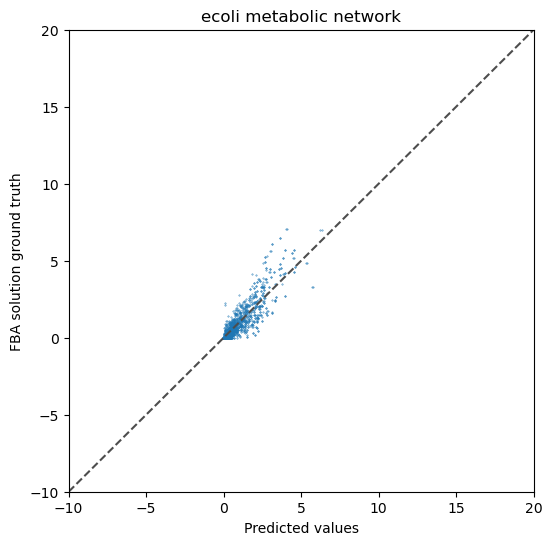

In [23]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.scatter(x = results['pred'].flatten(), y = results['label'].flatten(), s = 0.11)
ax.plot([-10, 20], [-10, 20], ls="--", c=".3")
ax.set(xlim=(-10, 20), ylim=(-10, 20))
ax.set_xlabel("Predicted values")
ax.set_ylabel("FBA solution ground truth")
ax.set_title("ecoli metabolic network")
fig.show()
plt.savefig('ecoli_linear_network.pdf', dpi=300)

In [24]:
results['label'].flatten().shape

(1432,)

In [25]:
results['pred'].flatten().shape

(1432,)

In [26]:
from scipy.stats import pearsonr
pcc, _ = pearsonr(results['label'].flatten(), results['pred'].flatten())
print("Pearson Correlation Coefficient:", pcc)


Pearson Correlation Coefficient: 0.8810461703762344
